# Spectral Resolution Tests

### Using synthetic spectra, how well can we determine wavelength and plate scale for TOLIMAN?

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline
import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
mpl.rcParams['font.size']=14               #10 
mpl.rcParams['savefig.dpi']= 200             #72 

import pysynphot as S

import specutils
from specutils.spectra import Spectrum1D
from astropy.io import fits as pyfits
from astropy.wcs import WCS
from astropy.io import fits
from scipy.ndimage.filters import gaussian_filter1d

INFO:root:Successfully loaded reader "cubetest1".
INFO:root:Successfully loaded reader "tabular-fits".
INFO:root:Successfully loaded reader "wcs1d-fits".


In [2]:
# use Phoenix models for Teff, metallicity (dex), log g in that order 

# alpha cen A: Teff = 5790, Z = 0.20, log g = 4.30
acenA = S.Icat('phoenix',5790,0.2,4.30)

# alpha cen B: Teff = 5260, Z = 0.23, log g = 4.37
acenB = S.Icat('phoenix',5260,0.23,4.37)

In [3]:
wavels = np.linspace(3000,9000,50000)
specA = acenA.sample(wavels)
specB = acenB.sample(wavels)

## Let's plot some toy spectra

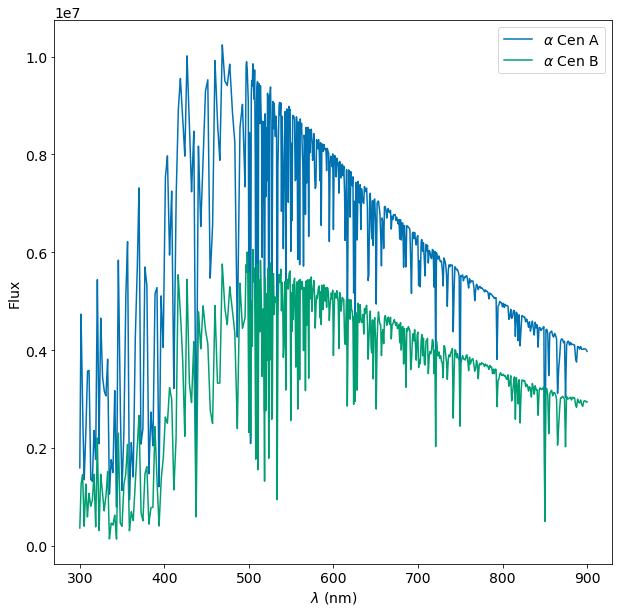

In [4]:
plt.plot(wavels/10.,specA,label=r'$\alpha$ Cen A')
plt.plot(wavels/10.,specB,label=r'$\alpha$ Cen B')
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Flux')
plt.legend()

## For TOLIMAN let's assume optical properties of HST WFC3, with a 500-600 nm bandpass

In [5]:
bp = S.ObsBandpass('wfc3,uvis1,f547m')
bandpass = bp.sample(wavels)

(4975, 5950)

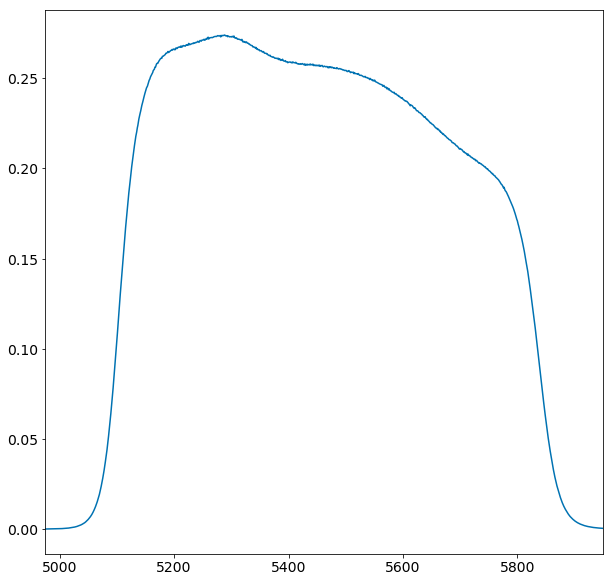

In [6]:
plt.plot(wavels,bandpass)
plt.xlim(4975,5950)

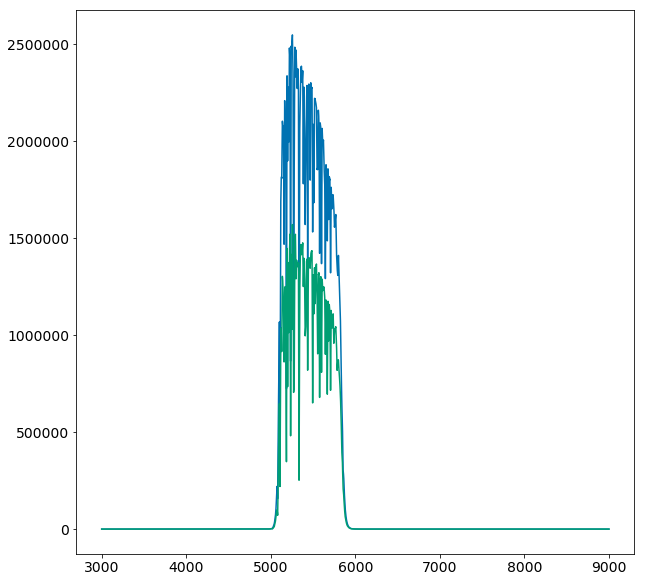

In [7]:
plt.plot(wavels,specA*bandpass)
plt.plot(wavels,specB*bandpass)

There is a UVES tutorial at http://www.astropy.org/astropy-tutorials/UVES.html

### Now what we want to do is simulate the change in centroid as you scan in temperature

In [8]:
T_surface = 5790
T_spot = 4700

fractions = np.linspace(0.01,0.15,15)
surface = S.Icat('phoenix',T_surface,0.2,4.30)
spot = S.Icat('phoenix',T_spot,0.2,4.30)

surf_spec = surface.sample(wavels)
spot_spec = spot.sample(wavels)

centres = []

for frac in fractions:
    this_spec = (1-frac)*surf_spec + (frac)*spot_spec
    this_spec *= bandpass
    
    centres.append(np.sum(wavels*this_spec)/np.sum(this_spec))
    
centres = np.array(centres)
diffs = (centres-centres[0])/centres[0]

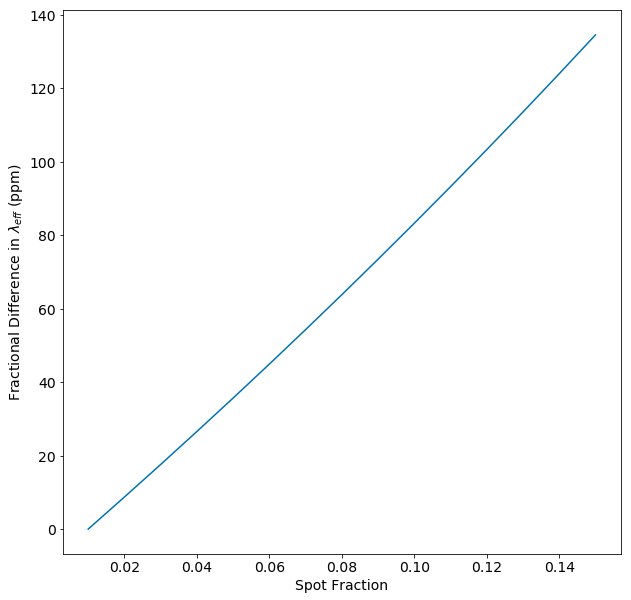

In [9]:
plt.plot(fractions,diffs*1e6)
plt.xlabel('Spot Fraction')
plt.ylabel(r'Fractional Difference in $\lambda_{eff}$ (ppm)')

### We want sub-ppm change in effective wavelength - let's try a narrower band?

In [10]:
nbp = S.ObsBandpass('wfc3,uvis1,f502n')
# nbp = S.ObsBandpass('wfc3,uvis1,f631n')
# nbp = S.ObsBandpass('wfc3,uvis1,f645n')

narrow = nbp.sample(wavels)

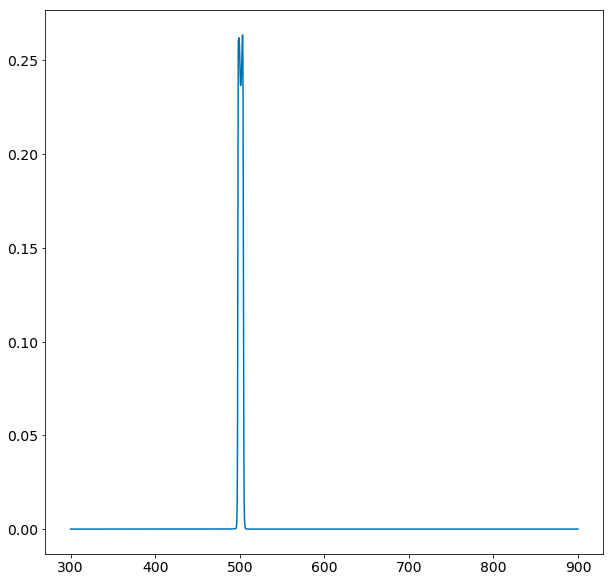

In [11]:
plt.plot(wavels/10.,narrow)
# plt.xlim(480,520)

In [12]:
T_surface = 5790
T_spot = 4700

fractions = np.linspace(0.01,0.15,15)
surface = S.Icat('phoenix',T_surface,0.2,4.30)
spot = S.Icat('phoenix',T_spot,0.2,4.30)

surf_spec = surface.sample(wavels)
spot_spec = spot.sample(wavels)

centres = []

for frac in fractions:
    this_spec = (1-frac)*surf_spec + (frac)*spot_spec
    this_spec *= narrow
    
    centres.append(np.sum(wavels*this_spec)/np.sum(this_spec))
    
centres = np.array(centres)
diffs = (centres-centres[0])/centres[0]

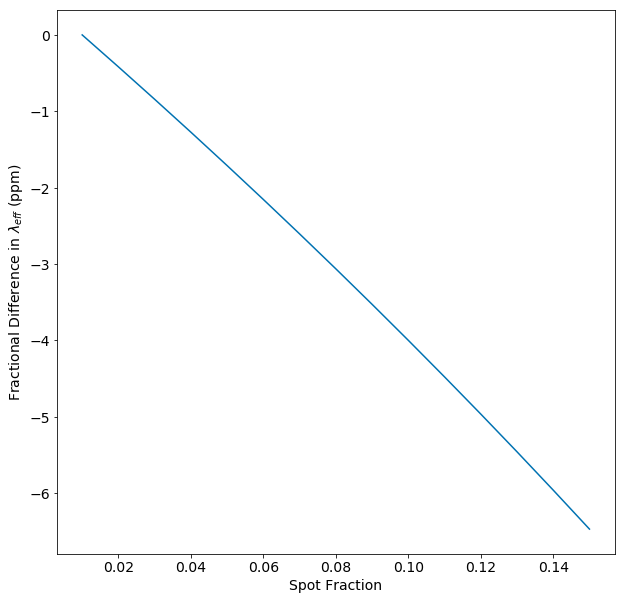

In [13]:
plt.plot(fractions,diffs*1e6)
plt.xlabel('Spot Fraction')
plt.ylabel(r'Fractional Difference in $\lambda_{eff}$ (ppm)')

### So a 100 nm bandpass gives you ~ tens of ppm change in effective wavelength, but 10 nm gives you ~ a few ppm. It is better to put this in some spectral regions than others! 

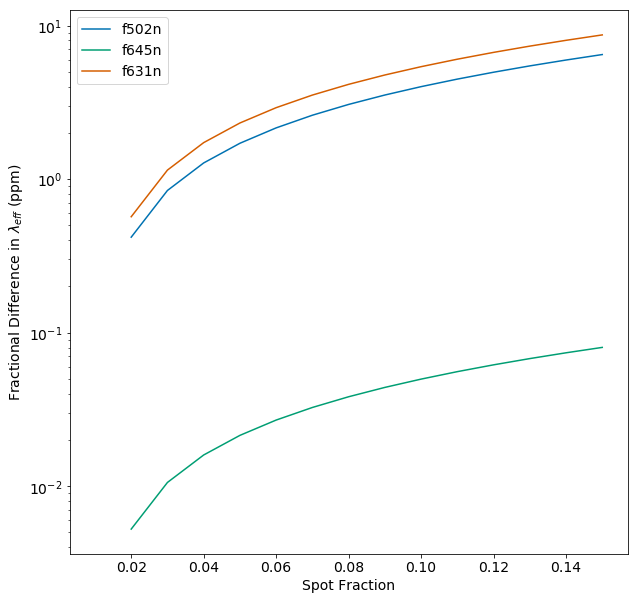

In [14]:
filters = ['f502n','f645n','f631n']

for filt in filters:
    
    nbp = S.ObsBandpass('wfc3,uvis1,%s'%filt)

    narrow = nbp.sample(wavels)
    
    centres = []

    for frac in fractions:
        this_spec = (1-frac)*surf_spec + (frac)*spot_spec
        this_spec *= narrow

        centres.append(np.sum(wavels*this_spec)/np.sum(this_spec))

    centres = np.array(centres)
    diffs = np.abs((centres-centres[0])/centres[0])
    
    plt.semilogy(fractions,diffs*1e6,label=filt)
    
    
plt.xlabel('Spot Fraction')
plt.ylabel(r'Fractional Difference in $\lambda_{eff}$ (ppm)')
plt.legend()

# Now we want to see how well we can infer T_surface, T_spot, frac, and a scale! 

In [15]:
def model(T_surface,T_spot,frac,scale,wavels):
    surface = (1-frac)*S.Icat('phoenix',T_surface,0.2,4.30)
    spot = frac*S.Icat('phoenix',T_spot,0.2,4.30)
    spec = surface+spot
    spec.redshift(scale)
    return spec(wavels)


In [16]:
wavels = np.linspace(4975,5950,1000)
bp = S.ObsBandpass('wfc3,uvis1,f547m')
bandpass = bp.sample(wavels)


In [17]:
%%time

for j in range(50):
    data = model(T_surface,T_spot,0.15,0.,wavels)#*bandpass

CPU times: user 9.83 s, sys: 213 ms, total: 10 s
Wall time: 13.4 s


# Define a new Icat

In [18]:
from pysynphot import spectrum
from pysynphot import locations
import numpy as N
import os
from copy import copy, deepcopy

from pysynphot.Cache import CATALOG_CACHE

import pysynphot.exceptions as exceptions

In [19]:

class Icat(spectrum.TabularSourceSpectrum):
    """This class constructs a model from the grid available in
    :ref:`catalogs <pysynphot-spec-atlas>`.
    Specifically, they are :ref:`pysynphot-appendixa-ck04`,
    :ref:`pysynphot-appendixa-kurucz1993`, and
    :ref:`pysynphot-appendixa-phoenix`.
    Each grid contains a master file named "catalog.fits", as
    defined by ``pysynphot.locations.CAT_TEMPLATE``.
    The basis spectra are located at ``pysynphot.locations.KUR_TEMPLATE``.
    You may inspect the data files in CRDS to see how they
    are formatted.
    Parameters
    ----------
    catdir : {'ck04models', 'k93models', 'phoenix'}
        Name of directory holding the catalogs.
    Teff : float
        Effective temperature of model, in Kelvin.
    metallicity : float
        Metallicity of model.
    log_g : float
        Log surface gravity of model.
    Attributes
    ----------
    name : str
        Short description of the spectrum.
    parameter_names : list of str
        Names for model parameters. This is used for error reporting.
    warnings : dict
        To store warnings.
    isAnalytic : bool
        This is always `False`.
    waveunits, fluxunits : `~pysynphot.units.Units`
        Catalog units for wavelength and flux.
    wave, flux : array_like
        Wavelength set and associated flux in catalog units.
    Raises
    ------
    pysynphot.exceptions.ParameterOutOfBounds
        Given parameter value is out of bounds.
    Examples
    --------
    >>> spec = S.Icat('k93models', 6440, 0, 4.3)
    """
    def __init__(self,catdir,Teff,metallicity,log_g,spectra_in=None,save_grid=False):
        self.isAnalytic=False

        # this is useful for reporting in exceptions which parameter is
        # causing the problems.
        self.parameter_names = ['Teff','metallicity','log G']

        filename = locations.CAT_TEMPLATE.replace('*',catdir)
        self.name="%s(Teff=%g,z=%g,logG=%g)"%(catdir,Teff,metallicity,log_g)
        
        if spectra_in is not None:
            sp1, sp2, sp3, sp4, sp5, sp6, sp7, sp8 = spectra_in
        else:
            
            if filename in CATALOG_CACHE:
                indices = CATALOG_CACHE[filename]
            else:
                table = pyfits.open(filename)

                indexList = table[1].data.field('INDEX')
                filenameList = table[1].data.field('FILENAME')

                table.close()

                indices = self._getArgs(indexList, filenameList)

                CATALOG_CACHE[filename] = indices

            list0,list1 = self._breakList(indices, 0, Teff)

            list2,list3 = self._breakList(list0, 1, metallicity)
            list4,list5 = self._breakList(list1, 1, metallicity)

            list6,list7   = self._breakList(list2, 2, log_g)
            list8,list9   = self._breakList(list3, 2, log_g)
            list10,list11 = self._breakList(list4, 2, log_g)
            list12,list13 = self._breakList(list5, 2, log_g)
            
            sp1 = self._getSpectrum(list6[0],  catdir)
            sp2 = self._getSpectrum(list7[0],  catdir)
            sp3 = self._getSpectrum(list8[0],  catdir)
            sp4 = self._getSpectrum(list9[0],  catdir)
            sp5 = self._getSpectrum(list10[0], catdir)
            sp6 = self._getSpectrum(list11[0], catdir)
            sp7 = self._getSpectrum(list12[0], catdir)
            sp8 = self._getSpectrum(list13[0], catdir)
            
            if save_grid:
                self.grid = N.copy([sp1,sp2,sp3,sp4,sp5,sp6,sp7,sp8]).tolist()

        spa1 = self._interpolateSpectrum(sp1, sp2, log_g)
        spa2 = self._interpolateSpectrum(sp3, sp4, log_g)
        spa3 = self._interpolateSpectrum(sp5, sp6, log_g)
        spa4 = self._interpolateSpectrum(sp7, sp8, log_g)

        spa5 = self._interpolateSpectrum(spa1, spa2, metallicity)
        spa6 = self._interpolateSpectrum(spa3, spa4, metallicity)

        spa7 = self._interpolateSpectrum(spa5, spa6, Teff)

        sp = spa7[0]

        self._wavetable = sp.GetWaveSet()
        self._fluxtable = sp(self._wavetable)
        self.waveunits = sp.waveunits
        self.fluxunits = sp.fluxunits
        self.warnings = {}

    def _getArgs(self, indices, filenames):
        results = []

        for i,index in enumerate(indices):
            list1 = [float(x) for x in index.split(',')]
            list1.append(filenames[i])
            results.append(list1)

        return results

    def _breakList(self, inList, index, parameter):
        par = float(parameter)

        array = [parameters[index] for parameters in inList]
        array = N.array(array, dtype=N.float64)

        upperArray = array[array >= par]
        lowerArray = array[array <= par]

        if upperArray.size == 0:
            maxAllowed = array.max()
            s = "Parameter '%s' exceeds data. Max allowed=%f, entered=%f."
            s = s % (self.parameter_names[index], maxAllowed, parameter)
            raise exceptions.ParameterOutOfBounds(s)

        elif lowerArray.size == 0:
            minAllowed = array.min()
            s = "Parameter '%s' exceeds data. Min allowed=%f, entered=%f."
            s = s % (self.parameter_names[index], minAllowed, parameter)
            raise exceptions.ParameterOutOfBounds(s)

        upper = upperArray.min()
        lower = lowerArray.max()

        upperList = []
        lowerList = []

        for i,parameters in enumerate(inList):
            if array[i] >= par and array[i] <= upper:
                upperList.append(parameters)
            if array[i] >= lower and array[i] <= par:
                lowerList.append(parameters)

        return upperList, lowerList

    def _getSpectrum(self, parlist, basename):
        name = parlist[3]

        filename = name.split('[')[0]
        column = name.split('[')[1][:-1]

        filename = locations.KUR_TEMPLATE.replace('*',
                                                  os.path.join(basename,filename))
        sp = spectrum.TabularSourceSpectrum(filename, fluxname=column)

        result = []
        for member in parlist:
            result.append(member)

        result.pop()
        result.append(sp)

        return result

    def _interpolateSpectrum(self, sp1, sp2, par):
        spectrum1 = sp1.pop()
        spectrum2 = sp2.pop()
        par1 = sp1.pop()
        par2 = sp2.pop()

        if par1 == par2:
            sp = spectrum1
        else:
            a = (par1 - par) / (par1 - par2)
            b = 1.0 - a

            sp = a * spectrum2 + b * spectrum1

        result = []
        for member in sp1:
            result.append(member)
        result.append(sp)

        return result

In [20]:
def model(T_surface,T_spot,frac,scale,wavels,grid_surf,grid_spot):
    surface = (1-frac)*Icat('phoenix',T_surface,0.2,4.30,spectra_in=grid_surf)
    spot = frac*Icat('phoenix',T_spot,0.2,4.30,spectra_in=grid_spot)
    spec = surface+spot
    spec = spec.redshift(scale)
    return spec(wavels)

In [21]:
wavels = np.linspace(4975,5950,3000)
bp = S.ObsBandpass('wfc3,uvis1,f547m')
bandpass = bp.sample(wavels)


In [22]:
T_surface = 5790
T_spot = 4650


surface = Icat('phoenix',T_surface,0.2,4.30,save_grid=True)
spot = Icat('phoenix',T_spot,0.2,4.30,save_grid=True)

grid_surf=np.copy(surface.grid).tolist()
grid_spot=np.copy(spot.grid).tolist()

In [23]:
Teffs = []
Zs = []
loggs = []
for j in range(8):
    Teffs.append(surface.grid[j][0])
    Zs.append(surface.grid[j][1])
    loggs.append(surface.grid[j][2])
    
Tmin, Tmax = np.min(Teffs), np.max(Teffs)
Zmin, Zmax = np.min(Zs), np.max(Zs)
loggmin, loggmax = np.min(loggs), np.max(loggs)

print Tmin, Tmax
print Zmin, Zmax
print loggmin, loggmax

5700.0 5800.0
-0.0 0.3
4.0 4.5


In [24]:
Teffs = []
Zs = []
loggs = []
for j in range(8):
    Teffs.append(spot.grid[j][0])
    Zs.append(spot.grid[j][1])
    loggs.append(spot.grid[j][2])
    
Tmin, Tmax = np.min(Teffs), np.max(Teffs)
Zmin, Zmax = np.min(Zs), np.max(Zs)
loggmin, loggmax = np.min(loggs), np.max(loggs)

print Tmin, Tmax
print Zmin, Zmax
print loggmin, loggmax

4600.0 4700.0
-0.0 0.3
4.0 4.5


In [25]:
%%time
for j in range(500):
    data = model(T_surface,T_spot,0.15,0.,wavels,np.copy(surface.grid).tolist(),np.copy(spot.grid).tolist())#*bandpass

CPU times: user 8.61 s, sys: 13.3 ms, total: 8.62 s
Wall time: 8.64 s


In [26]:
100*1000/500*8.88/60

29.600000000000005

## So we have it down to 60 ms/evaluation. Let's try and make some data!

In [27]:
data = model(5760,4680,0.13,0.1,wavels,deepcopy(surface.grid),deepcopy(spot.grid))*bandpass
data2 = model(5760,4680,0.13,0.11,wavels,deepcopy(surface.grid),deepcopy(spot.grid))*bandpass

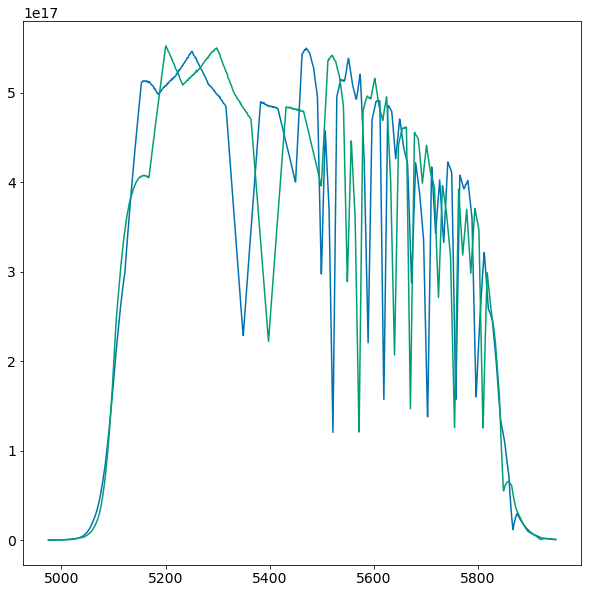

In [28]:
plt.plot(wavels,data)
plt.plot(wavels,data2)

### Now do MCMC!

In [29]:
import emcee
import scipy.optimize as opt


In [30]:
# parameters are T_surface, T_spot, frac, scale
#initialise
ndim, nwalkers = 4, 100
true_params = np.array([5760,4680,0.13,0.1])
nsteps = 1000
p0 = [true_params*(1+0.0001*np.random.randn(ndim)) for i in range(nwalkers)]

error = data*0.001

In [31]:
def lnprob(walker,wavels,grid_surface,grid_spotted):
    try:
        chi2 = np.sum(
            (model(walker[0],walker[1],walker[2],walker[3],wavels,deepcopy(grid_surface),deepcopy(grid_spotted))
             *bandpass-data)**2
            /error**2)
        return -chi2/2.
    except:
        return -np.inf

In [32]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=[wavels,deepcopy(surface.grid),deepcopy(spot.grid)])


In [33]:
%%time
pos,prob,state = sampler.run_mcmc(p0, 100)

CPU times: user 3min 17s, sys: 575 ms, total: 3min 18s
Wall time: 3min 18s


In [34]:
sampler.reset()


In [35]:
%%time 
nsteps = 1000
pos,prob,state = sampler.run_mcmc(pos,nsteps)


CPU times: user 32min 44s, sys: 3.2 s, total: 32min 47s
Wall time: 32min 56s


In [36]:
import corner

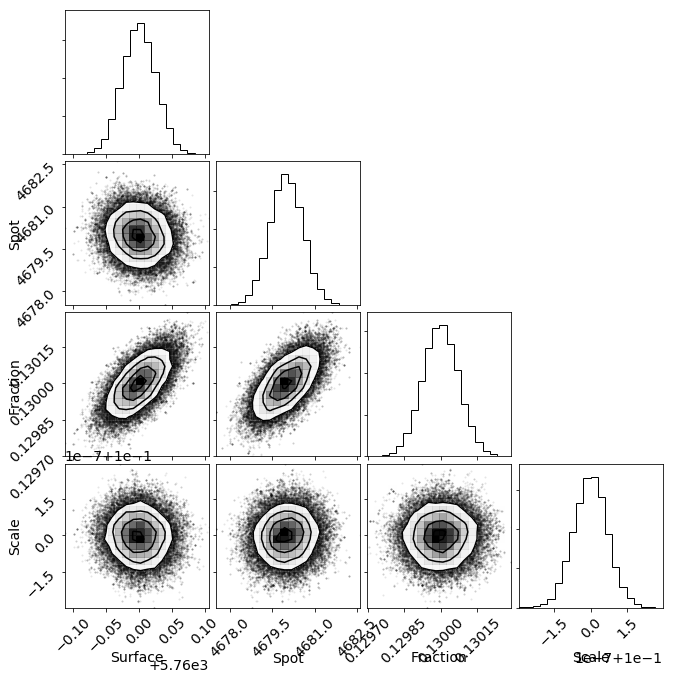

In [37]:
figure = corner.corner(sampler.flatchain,labels=["Surface","Spot","Fraction","Scale"])

In [38]:
estimates = np.nanmedian(sampler.flatchain,axis=0)
sig = np.nanstd(sampler.flatchain,axis=0)

In [39]:
for j in range(4):
    print estimates[j],'+-',sig[j]

5759.99985186 +- 0.0252912003436
4679.99024529 +- 0.581588925768
0.129998606311 +- 7.42189467585e-05
0.0999999985072 +- 6.97648565564e-08
